# Hyperparameter Optimization

## Parameter vs. Hyperparameter

A **model parameter** is a configuration variable that is internal to the model and whose value can be estimated from data.

A **model hyperparameter** is a configuration that is external to the model and whose value cannot be estimated from data.


<table><thead><tr><th>PARAMETERS</th><th>HYPERPARAMETER</th></tr></thead><tbody><tr><td>They are required for making predictions</td><td>They are required for estimating the model parameters</td></tr><tr><td>They are estimated by optimization algorithms(Gradient Descent, Adam, Adagrad)</td><td>They are estimated by hyperparameter tuning</td></tr><tr><td>They are not set manually</td><td>They are set manually</td></tr><tr><td>The final parameters found after training will decide how the model will perform on unseen data</td><td>The choice of hyperparameters decide how efficient the training is. In gradient descent the learning rate decide how efficient and accurate the optimization process is in estimating the parameters</td></tr></tbody></table>

## About hyperparameter tuning

**Hyperparameter tuning (or hyperparameter optimization) is the process of determining the right combination of hyperparameters that maximizes the model performance.**

- **`Manual hyperparameter tuning:`**
    - Manual hyperparameter tuning involves experimenting with different sets of hyperparameters manually i.e. each trial with a set of hyperparameters will be performed by you. This technique will require a robust experiment tracker which could track a variety of variables from images, logs to system metrics. https://mlflow.org/docs/latest/index.html

- **`Automated hyperparameter tuning:`**
    - Automated hyperparameter tuning utilizes already existing algorithms to automate the process.

## Hyperparameter tuning methods 

**Grid Search**

- The Pros: It’s easy to implement. Can be easily parallelized.
- The Cons: It’s insanely computationally expensive.
- Should I use it: Probably not. Grid search is terribly inefficient. Even if you want to keep it simple, you’re better off using random search.

**Random Search**

<img src="images/img_01.png">

- The Pros: Can be easily parallelized. Just as simple as grid search, but a bit better performance.
- The Cons: While it gives better performance than grid search, it is still just as computationally intensive.
- Should I use it: If trivial parallelization and simplicity are of utmost importance, go for it.

In [6]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV # uporabimo ta class namesto GridSearch kot pri preteklih primerih
from scipy.stats import uniform # uporabimo za normalno porazdelitev znotraj območja

iris = load_iris()

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,random_state=0)
distributions = dict(C=uniform(loc=0, scale=4),penalty=['l2', 'l1'])

clf = RandomizedSearchCV(logistic, distributions, random_state=0, n_iter=20, n_jobs=1)
# n_iter ... max število iteracij znotraj grida

search = clf.fit(iris.data, iris.target)
search.best_params_

{'C': 2.195254015709299, 'penalty': 'l1'}

In [2]:
search.best_estimator_

LogisticRegression(C=2.195254015709299, max_iter=200, penalty='l1',
                   random_state=0, solver='saga', tol=0.01)

**Bayesian Optimization**
- poskuša minimizrati loss funkcijo - pametna hiperopzimizacija.

- The Pros: Bayesian optimization gives better results than both grid search and random search.
- The Cons: It's not as easy to parallelize.
- Should I Use It: In most cases.

**Tree-structured Parzen estimators (TPE)**
- bayes in TPE nista dobro podprti v sklearn-u. V nadaljevanju prikazane druge knjižnice za napredne hiperoptimizacije.

## Tips for hyperparameter search

- **Specifying an objective metric**
- **Specifying multiple metrics for evaluation**

In [7]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [8]:
X, y = make_hastie_10_2(n_samples=8000, random_state=42)

# The scorers can be either one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid={"min_samples_split": range(2, 403, 20)},
    scoring=scoring,
    refit="AUC",
    n_jobs=2,
    return_train_score=True,
)
gs.fit(X, y)
results = gs.cv_results_

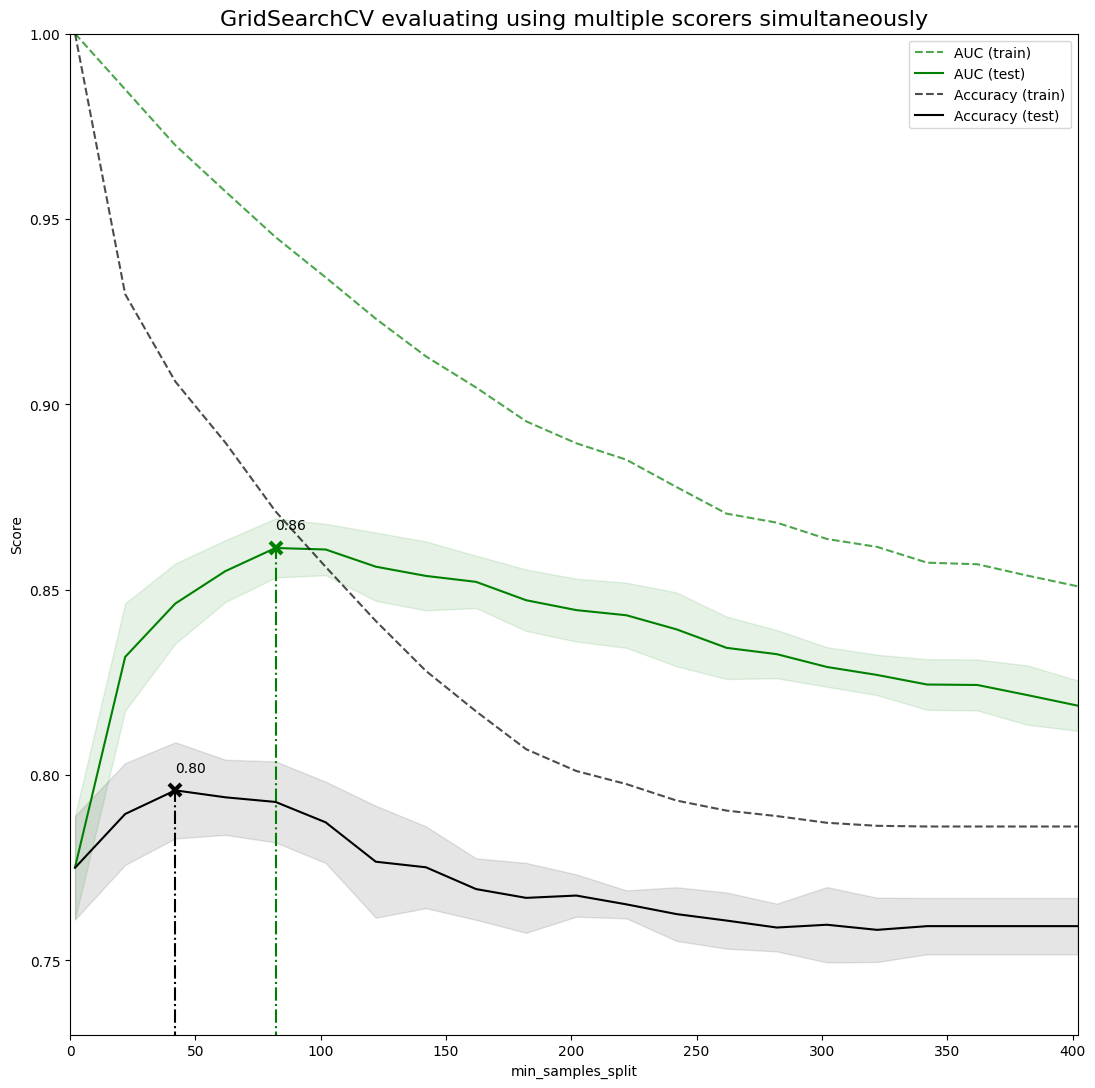

In [9]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_min_samples_split"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

- **Composite estimators and parameter spaces**

## Hyperopt
- (malo outdated - danes se bolj uporablja Optuna, ki je predstavljena v nadaljevanju)

**Hyperopt is an open source hyperparameter tuning library that uses a Bayesian approach to find the best values for the hyperparameters.**

Install hyperopt from PyPI: `pip install hyperopt`

Documentation: http://hyperopt.github.io/hyperopt/

Tutorial: https://github.com/hyperopt/hyperopt/wiki/FMin

Hyperopt's job is to find the best value of a scalar-valued, possibly-stochastic function over a set of possible arguments to that function.

Currently three algorithms are implemented in hyperopt:
- Random Search
- Tree of Parzen Estimators (TPE)
- Adaptive TPE

> [Hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn) is Hyperopt-based model selection among machine learning algorithms in scikit-learn.

### Example: Water quality 

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [11]:
# read in the data and info
data = pd.read_csv('data/water_potability.csv')

# remove missing values
data = data.dropna()

data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0


In [12]:
# split to train and test
X = data.drop(['Potability'], axis = 1)
y = data['Potability']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=200)

# build the model
model = RandomForestClassifier(n_estimators=300, max_features='sqrt', random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# print out the score accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6724565756823822


In [13]:
# read in hyperopt values
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

In [20]:
# define the function we want to minimise
# pomemben del je definicija loss funkcije
def objective(n_estimators):
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_features='sqrt',
                                   random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

In [15]:
# define the values to search over for n_estimators
search_space = hp.randint('n_estimators', 200, 1000)

In [16]:
# set the hyperparam tuning algorithm
algorithm=tpe.suggest

In [17]:
best_params = fmin(
  fn=objective,
  space=search_space,
  algo=algorithm,
  max_evals=10) # v praksi 200+

100%|██████████| 10/10 [00:56<00:00,  5.61s/trial, best loss: -0.6774193548387096]


In [18]:
print(best_params)

{'n_estimators': 360}


In [19]:
# redefine the function usng a wider range of hyperparameters
def objective(search_space):
    model = RandomForestClassifier(**search_space, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# new search space
search_space={'n_estimators':hp.randint('n_estimators',200,1000),
              
              'max_depth': hp.randint('max_depth',10,200),           
            
            'min_samples_split':hp.uniform('min_samples_split',0,1),   
             'min_samples_leaf':hp.randint('min_samples_leaf',1,10),
              
               'criterion':hp.choice('criterion', ['gini','entropy']), # hp.choice( uporabimo za nabor kategorij
                
           'max_features':hp.choice('max_features',['sqrt', 'log2']) } # hp.choice( uporabimo za nabor kategorij

# implement Hyperopt
best_params = fmin(
  fn=objective,
  space=search_space,
  algo=algorithm,
  max_evals=15) # v praksi 200+

100%|██████████| 15/15 [00:51<00:00,  3.44s/trial, best loss: -0.6724565756823822]


In [21]:
space_eval(search_space, best_params)

{'criterion': 'entropy',
 'max_depth': 95,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 0.007382022713466774,
 'n_estimators': 985}

## Optuna

**An open source hyperparameter optimization framework to automate hyperparameter search.**

Web page: https://optuna.org/

Docs: https://optuna.readthedocs.io/en/stable/index.html

Tutorial: https://optuna.readthedocs.io/en/stable/tutorial/index.html

Optuna can be installed with pip: `pip install optuna`

Optuna is framework agnostic. You can use it with any machine learning or deep learning framework.

Optuna has modern functionalities as follows:
- Lightweight, versatile, and platform agnostic architecture. Handle a wide variety of tasks with a simple installation that has few requirements.
- Pythonic search spaces. Define search spaces using familiar Python syntax including conditionals and loops.
- Efficient optimization algorithms. Adopt state-of-the-art algorithms for sampling hyperparameters and efficiently pruning unpromising trials.
- Easy parallelization. Scale studies to tens or hundreds of workers with little or no changes to the code.
- Quick visualization. Inspect optimization histories from a variety of plotting functions.

Optuna provides the following sampling algorithms:
- Grid Search implemented in GridSampler
- Random Search implemented in RandomSampler
- Tree-structured Parzen Estimator algorithm implemented in TPESampler
- CMA-ES based algorithm implemented in CmaEsSampler
- Algorithm to enable partial fixed parameters implemented in PartialFixedSampler
- Nondominated Sorting Genetic Algorithm II implemented in NSGAIISampler
- A Quasi Monte Carlo sampling algorithm implemented in QMCSampler

In [22]:
import optuna
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection

In [23]:
def objective():
    iris = sklearn.datasets.load_iris()  # Prepare the data.
    
    clf = sklearn.ensemble.RandomForestClassifier(    
        n_estimators=5, max_depth=3)  # Define the model.
    
    return sklearn.model_selection.cross_val_score(
        clf, iris.data, iris.target, n_jobs=-1, cv=3).mean()  # Train and evaluate the model.

print('Accuracy: {}'.format(objective()))

Accuracy: 0.9666666666666667


In [24]:
# Optimize hyperparameters of the model
import optuna

def objective(trial):
    iris = sklearn.datasets.load_iris()
    
    n_estimators = trial.suggest_int('n_estimators', 2, 20)
    max_depth = int(trial.suggest_float('max_depth', 1, 32, log=True))
    
    clf = sklearn.ensemble.RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth)
    
    return sklearn.model_selection.cross_val_score(
        clf, iris.data, iris.target, n_jobs=-1, cv=3).mean()

In [25]:
study = optuna.create_study(direction='maximize') # povemo ali zelimo minimizirati ali maximizirati
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-03-06 17:40:15,096] A new study created in memory with name: no-name-e7a98244-9149-4ab7-b36b-493c78229831
[I 2023-03-06 17:40:15,898] Trial 0 finished with value: 0.9666666666666667 and parameters: {'n_estimators': 20, 'max_depth': 1.6811350034787669}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-03-06 17:40:16,686] Trial 1 finished with value: 0.9666666666666667 and parameters: {'n_estimators': 7, 'max_depth': 5.770044890504877}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-03-06 17:40:16,715] Trial 2 finished with value: 0.9666666666666667 and parameters: {'n_estimators': 8, 'max_depth': 3.823677438006332}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-03-06 17:40:16,754] Trial 3 finished with value: 0.96 and parameters: {'n_estimators': 13, 'max_depth': 12.759045773586818}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-03-06 17:40:16,783] Trial 4 finished with value: 0.9533333333333333 and parameters: {'n_estimators': 10, 'max_depth'

Accuracy: 0.9666666666666667
Best hyperparameters: {'n_estimators': 20, 'max_depth': 1.6811350034787669}


In [26]:
import sklearn.svm

def objective(trial):
    iris = sklearn.datasets.load_iris()

    classifier = trial.suggest_categorical('classifier', ['RandomForest', 'SVC'])
    
    if classifier == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 2, 20)
        max_depth = int(trial.suggest_float('max_depth', 1, 32, log=True))

        clf = sklearn.ensemble.RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth)
    else:
        c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)
        
        clf = sklearn.svm.SVC(C=c, gamma='auto')

    return sklearn.model_selection.cross_val_score(
        clf, iris.data, iris.target, n_jobs=-1, cv=3).mean()

In [27]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-03-06 17:41:07,618] A new study created in memory with name: no-name-70c0da1f-8fd8-43a7-9ca2-717c9bb97aae
[I 2023-03-06 17:41:07,632] Trial 0 finished with value: 0.32 and parameters: {'classifier': 'SVC', 'svc_c': 0.0009045180894086956}. Best is trial 0 with value: 0.32.
[I 2023-03-06 17:41:07,645] Trial 1 finished with value: 0.9333333333333332 and parameters: {'classifier': 'RandomForest', 'n_estimators': 2, 'max_depth': 2.718545400558641}. Best is trial 1 with value: 0.9333333333333332.
[I 2023-03-06 17:41:07,690] Trial 2 finished with value: 0.9533333333333333 and parameters: {'classifier': 'RandomForest', 'n_estimators': 17, 'max_depth': 10.281217050092664}. Best is trial 2 with value: 0.9533333333333333.
[I 2023-03-06 17:41:07,703] Trial 3 finished with value: 0.96 and parameters: {'classifier': 'SVC', 'svc_c': 5491378.631571285}. Best is trial 3 with value: 0.96.
[I 2023-03-06 17:41:07,714] Trial 4 finished with value: 0.9466666666666667 and parameters: {'classifier': '

Accuracy: 0.9866666666666667
Best hyperparameters: {'classifier': 'SVC', 'svc_c': 3.9974290491975717}


In [28]:
optuna.visualization.plot_optimization_history(study)

In [29]:
optuna.visualization.plot_slice(study)

In [30]:
optuna.visualization.plot_contour(study, params=['n_estimators', 'max_depth'])

> Optuna Dashboard: https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html